# Imports

In [61]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

# Datasets

In [2]:
data = CSV.read("data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


Look at class labels to see if dataset is imbalanced

In [5]:
label_counts = countmap(data[:Class_Name])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [6]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [7]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


In [8]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [9]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [10]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class_Name])) # gives 70:30 split

([595, 102, 55, 568, 425, 389, 146, 63, 372, 250  …  195, 500, 571, 533, 112, 396, 297, 106, 303, 261], [444, 144, 546, 43, 19, 173, 365, 423, 27, 218  …  293, 614, 90, 471, 13, 134, 296, 79, 395, 415])

In [11]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0776255707762557
 0.4611872146118721
 0.4611872146118721

In [12]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.08021390374331551
 0.45989304812834225
 0.45989304812834225

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [13]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [14]:
@load KNNClassifier

import MLJModels ✔
import NearestNeighbors 

┌ Info: Loading into module "Main": 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:70


✔
import MLJModels.NearestNeighbors_ ✔


KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @786

## K Nearest Neighbors
* Use different values of k.

1. https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/
1. https://github.com/KristofferC/NearestNeighbors.jl

#### No Pre-Processing

In [15]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @659

In [16]:
KNN = machine(knn, X, y)

Machine{KNNClassifier} @726 trained 0 times.
  args: 
    1:	Source @331 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @859 ⏎ `AbstractArray{Multiclass{3},1}`


In [17]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @726.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @726 trained 1 time.
  args: 
    1:	Source @331 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @859 ⏎ `AbstractArray{Multiclass{3},1}`


In [18]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 2.74          │ [3.36, 2.27, 2.28, 3.65, 3.31, 1.59]       │
│ acc           │ 0.834         │ [0.762, 0.846, 0.817, 0.837, 0.856, 0.885] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[36.0, 0.916, ..., 2.22e-16], [0.511, 2.22e-16, ..., 1.61], [2.22e-16, 0.511, ..., 2.22e-16], [0.223, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [19]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{4},Float64,1,4},Distances.Euclidean,Float64}
  Number of points: 521
  Dimensions: 4
  Metric: Distances.Euclidean(0.0)
  Reordered: true,)

#### With Pre-Processing

In [20]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @417

In [21]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:])
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @764.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


In [22]:
KNN = machine(knn, X_stand, y)

Machine{KNNClassifier} @147 trained 0 times.
  args: 
    1:	Source @529 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @478 ⏎ `AbstractArray{Multiclass{3},1}`


In [23]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @147.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @147 trained 1 time.
  args: 
    1:	Source @529 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @478 ⏎ `AbstractArray{Multiclass{3},1}`


In [24]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 2.69          │ [4.67, 1.61, 3.32, 2.62, 2.66, 1.29]       │
│ acc           │ 0.818         │ [0.733, 0.856, 0.817, 0.856, 0.808, 0.837] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 1.61, ..., 2.22e-16], [1.61, 0.223, ..., 0.223], [0.223, 36.0, ..., 1.61], [2.22e-16, 2.22e-16, ..., 0.223], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [26]:
# evaluate!(KNN, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [27]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{4},Float64,1,4},Distances.Euclidean,Float64}
  Number of points: 521
  Dimensions: 4
  Metric: Distances.Euclidean(0.0)
  Reordered: true,)

### GridSearch / RandomSearch

#### Euclidean

In [28]:
knn_grid = KNNClassifier()

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @502

In [36]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=10, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [37]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1])

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @539],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @869

In [38]:
self_tuning_knn = machine(self_tuning_knn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @781 trained 0 times.
  args: 
    1:	Source @914 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @821 ⏎ `AbstractArray{Multiclass{3},1}`


In [39]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @781.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:00


Machine{ProbabilisticTunedModel{Grid,…}} @781 trained 1 time.
  args: 
    1:	Source @914 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @821 ⏎ `AbstractArray{Multiclass{3},1}`


In [40]:
best = fitted_params(self_tuning_knn)
best

(best_model = KNNClassifier @391,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{4},Float64,1,4},Distances.Euclidean,Float64}
  Number of points: 438
  Dimensions: 4
  Metric: Distances.Euclidean(0.0)
  Reordered: true,),)

In [41]:
best.best_model

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @391

#### Manhattan

In [125]:
knn_grid = KNNClassifier(metric=Chebyshev())

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Chebyshev(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @708

In [126]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=10, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [127]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1])

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Chebyshev(),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @539],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @921

In [128]:
self_tuning_knn = machine(self_tuning_knn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @290 trained 0 times.
  args: 
    1:	Source @732 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @991 ⏎ `AbstractArray{Multiclass{3},1}`


In [129]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @290.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:00


Machine{ProbabilisticTunedModel{Grid,…}} @290 trained 1 time.
  args: 
    1:	Source @732 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @991 ⏎ `AbstractArray{Multiclass{3},1}`


In [130]:
best = fitted_params(self_tuning_knn)
best

(best_model = KNNClassifier @291,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{4},Float64,1,4},Euclidean,Float64}
  Number of points: 438
  Dimensions: 4
  Metric: Euclidean(0.0)
  Reordered: true,),)

In [131]:
best.best_model

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Chebyshev(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @291

### Learning Curve

In [132]:
data_schedule, training_losses, valid_losses = learn_curve(best.best_model, X[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 0.7, 0.42045454545454547)
(d, train_metric, valid_metric) = (15, 0.9333333333333333, 0.75)
(d, train_metric, valid_metric) = (20, 0.9, 0.7613636363636364)
(d, train_metric, valid_metric) = (25, 0.84, 0.8181818181818182)
(d, train_metric, valid_metric) = (30, 0.9, 0.8977272727272727)
(d, train_metric, valid_metric) = (35, 0.8285714285714286, 0.9090909090909091)
(d, train_metric, valid_metric) = (40, 0.875, 0.8977272727272727)
(d, train_metric, valid_metric) = (45, 0.8444444444444444, 0.875)
(d, train_metric, valid_metric) = (50, 0.82, 0.9090909090909091)
(d, train_metric, valid_metric) = (55, 0.8363636363636363, 0.9090909090909091)
(d, train_metric, valid_metric) = (60, 0.8, 0.9090909090909091)
(d, train_metric, valid_metric) = (65, 0.8307692307692308, 0.875)
(d, train_metric, valid_metric) = (70, 0.8142857142857143, 0.9090909090909091)
(d, train_metric, valid_metric) = (75, 0.76, 0.8863636363636364)
(d, train_metric, valid_metric) = (80, 0.825, 0.

(10:5:350, Any[0.7, 0.9333333333333333, 0.9, 0.84, 0.9, 0.8285714285714286, 0.875, 0.8444444444444444, 0.82, 0.8363636363636363  …  0.9180327868852459, 0.9193548387096774, 0.9174603174603174, 0.909375, 0.9107692307692308, 0.9, 0.9074626865671642, 0.9029411764705882, 0.9101449275362319, 0.9257142857142857], Any[0.42045454545454547, 0.75, 0.7613636363636364, 0.8181818181818182, 0.8977272727272727, 0.9090909090909091, 0.8977272727272727, 0.875, 0.9090909090909091, 0.9090909090909091  …  0.8409090909090909, 0.875, 0.875, 0.8863636363636364, 0.875, 0.8863636363636364, 0.8636363636363636, 0.875, 0.875, 0.875])

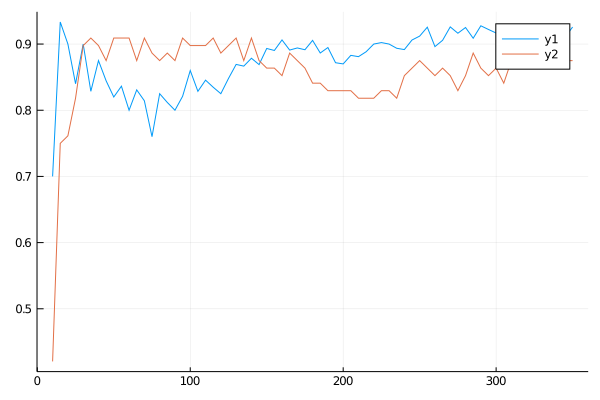

In [133]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

# Final Results

In [134]:
knn_final = KNNClassifier(K=best.best_model.K)

KNNClassifier(
    K = 9,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @695

In [135]:
KNN_Final = machine(knn_final, X, y)

Machine{KNNClassifier} @245 trained 0 times.
  args: 
    1:	Source @169 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @018 ⏎ `AbstractArray{Multiclass{3},1}`


In [136]:
fit!(KNN, rows=train)

┌ Info: Not retraining Machine{KNNClassifier} @147. Use `force=true` to force.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:322


Machine{KNNClassifier} @147 trained 8 times.
  args: 
    1:	Source @529 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @478 ⏎ `AbstractArray{Multiclass{3},1}`


In [137]:
ŷ = MLJ.predict(KNN, X_stand[test,:]);

In [138]:
cross_entropy(ŷ, y[test]) |> mean

2.1803242521858515

In [139]:
acc(ŷ, y[test])

0.8342245989304813

In [140]:
confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │      1      │      4      │      6      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      2      │     79      │      4      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │     12      │      3      │     76      │
└─────────────┴─────────────┴─────────────┴─────────────┘
